<a href="https://colab.research.google.com/github/sasha704/conjure-notebook/blob/tutorials/tutorials/NurseRostering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Nurse Rostering

Original [Nurse Rostering](https://conjure.readthedocs.io/en/latest/tutorials.html#nurse-rostering) by András Salamon, Nguyen Dang and Saad Attieh. Adapted by Alex Gallagher.

We now discuss a version of [Nurse Rostering](https://en.wikipedia.org/wiki/Nurse_scheduling_problem), a constrained scheduling problem. Variants of this problem are also known by other names, such as workforce planning and staff scheduling. Unlike versions of this problem studied by operations research practitioners and researchers (such as competition instances [CDDC+19](https://conjure.readthedocs.io/en/latest/zreferences.html#id4), we here focus on just a few of the simplest constraints.

Some nurses are available to work in a hospital. Each day is divided into a sequence of shifts, for instance an early-morning shift, a day shift, and a night shift. Each nurse should be assigned to work some shifts during the course of a period of consecutive days. A nurse can be assigned to at most one shift per day. Moreover, for each nurse we need to avoid some forbidden shift patterns within two consecutive days. For example, a nurse cannot work a night shift on one day, and an early-morning shift the next day. We also must make sure to meet the minimum number of nurses required for each shift. These demand values may vary between different days.

In [ ]:
!source <(curl -s https://raw.githubusercontent.com/conjure-cp/conjure-notebook/v0.0.2/scripts/install-colab.sh)
%load_ext conjure

Installing Conjure...
Conjure: The Automated Constraint Modelling Tool
Release version 2.4.0
Repository version a7382e3d9 (2022-11-21 10:41:03 +0000)


<IPython.core.display.Javascript object>

Conjure extension is loaded.
For usage help run: %conjure_help


##Initial specification

To begin with, let’s ignore the forbidden patterns, and focus instead on the elements needed to model the problem. We need nurses, shifts for each day, the minimum demand, and a roster.

`given nNurses, nDays : int(1..)`

`given shifts new type enum`

`letting days be domain int(1..nDays)`

`letting nurses be domain int(1..nNurses)`

`letting nShifts be |'shifts'|`

`given forbiddenPatterns : set of tuple (shifts, shifts)`

`given minimumDemand : function (total) (days, shifts) --> int(0..nNurses)`

`where`

   `forAll d : days .`

  `(sum s : shifts . minimumDemand((d,s))) <= nNurses`

`find roster: function (days, shifts) --> nurses`

`$ constraint 1 (Single assignment per day)`

`$ a nurse can be assigned to at most one shift per day`

`such that`

`forAll nurse : nurses .`

`forAll day : days .`

`(sum ((d,_),n) in roster . toInt(n=nurse /\ d=day)) <= 1`

This specification contains the basic elements. We made the choice to use an enumerated type for shifts, positive integers to number the nurses and the days, a set of forbidden patterns (each being a pair of shifts), and a total function mapping each shift slot to a number of nurses to represent the minimum demands. Because we only allow a nurse to work one shift each day, the forbidden patterns can only apply to one day and the next day, with the first shift in a forbidden pattern referring to the first day and the second shift referring to the subsequent day. We also added a `where` condition to ensure that instances are not trivially impossible, by requiring the minimum demand to never exceed the number of nurses.

We also need a test instance. Generating test instances is an interesting subject (for instance, see [AkgunDM+19](https://conjure.readthedocs.io/en/latest/zreferences.html#id5)) but here we have just made one up.

In [ ]:
%%conjure
letting nNurses be 5
letting nDays be 7
letting shifts be new type enum {Early, Late, Night}
letting forbiddenPatterns be {
   (Late,Early), (Night,Early), (Night,Late)
}
letting minimumDemand be function (
   (1,Early) --> 2, (1,Late) --> 2, (1,Night) --> 0,
   (2,Early) --> 1, (2,Late) --> 1, (2,Night) --> 2,
   (3,Early) --> 1, (3,Late) --> 1, (3,Night) --> 1,
   (4,Early) --> 0, (4,Late) --> 0, (4,Night) --> 1,
   (5,Early) --> 1, (5,Late) --> 1, (5,Night) --> 2,
   (6,Early) --> 2, (6,Late) --> 1, (6,Night) --> 1,
   (7,Early) --> 0, (7,Late) --> 1, (7,Night) --> 1
)
letting days be domain int(1..nDays)
letting nurses be domain int(1..nNurses)
letting nShifts be |`shifts`|

{}

We have 5 nurses, 7 days in the period, three shifts each day, three forbidden pairs of shifts, and some minimum demands for the various shifts.

##Changing an overly restrictive assumption

However, on further reflection this first specification is not correct. Since roster is a function `(days, shifts) --> nurses` only one nurse can be assigned to the same shift of the same day. This means that if the minimum demand asks for 2 or more nurses for a particular day and shift, then we can’t satisfy this demand. We need to remove the overly restrictive assumption enforced by our choice of representation for roster.


Let’s change the representation of `roster`, leaving the specification exactly the same up to and including the `where` condition. Instead of mapping each day/shift pair to a single nurse, we could map each day/shift pair to a set of nurses, map each nurse to a set of day/shift pairs, or map each combination of day and nurse to a shift (but with not all combinations needing to be assigned). Each of these choices leads to a slightly different way to model the problem; here we have picked the last. It is left as an exercise to try the others!

In [ ]:
%%conjure --solver=minion
find roster: function (days, nurses) --> shifts
$ constraint 1 (Single assignment per day)
$ a nurse can be assigned to at most one shift per day
$ NOTE: automatically satisfied because of how "roster" is defined

$ constraint 2 (Under staffing)
$ the number of nurses for each shift suffice for the minimum demand
such that
   forAll day : days .
      forAll shift : shifts .
         (sum ((d,_),s) in roster . toInt(d=day /\ s=shift))
            >= minimumDemand((day,shift))

$ constraint 3 (Shift type successions)
$ the shift type assignments of one nurse on two consecutive days
$ must not violate any forbidden succession
such that
   forAll d : int(1..(nDays-1)) .
      forAll n : nurses .
         !((roster(d,n), roster(d+1,n)) in forbiddenPatterns)

UsageError: Cell magic `%%conjure` not found.


Note that in this specification, the first constraint is automatically satisfied because of the way we have defined `roster` as a function from a day/nurse pair to a shift. So changing the representation of `roster` has not only removed the overly restrictive assumption that only one nurse can be assigned to a day/shift pair, but also dealt with the first real constraint.

We have added a second constraint to enforce the minimum demand for each shift, by requiring that the number of nurses mapped to each day/shift pair is at least as large as the minimum demand for that day/shift pair.

Finally, we have added a third constraint to ensure that forbidden shift patterns do not occur.

##Final model

Unfortunately, the second specification is not accepted by Conjure. The `roster` function is expecting a single pair as its argument, but we have given two arguments (a day and a nurse). We replace the last constraint by a version that corrects this syntax error:

`$ constraint 3 (Shift type successions)`

`$ the shift type assignments of one nurse on two consecutive days`

`$ must not violate any forbidden succession`

`such that`
   
`forAll d : int(1..(nDays-1)) .`

`forAll n : nurses .`

`!((roster((d,n)), roster((d+1,n))) in forbiddenPatterns)`

This is a specification that is acceptable to Conjure and which captures the key constraints we wanted to include.

Putting these constraints together gives us:

(*warning - running this cell may take quite a while!*)



In [ ]:
%%conjure --solver=minion
find roster: function (days, nurses) --> shifts
$ constraint 1 (Single assignment per day)
$ a nurse can be assigned to at most one shift per day
$ NOTE: automatically satisfied because of how "roster" is defined

$ constraint 2 (Under staffing)
$ the number of nurses for each shift suffice for the minimum demand
such that
   forAll day : days .
      forAll shift : shifts .
         (sum ((d,_),s) in roster . toInt(d=day /\ s=shift))
            >= minimumDemand((day,shift))

$ constraint 3 (Shift type successions)
$ the shift type assignments of one nurse on two consecutive days
$ must not violate any forbidden succession
such that
   forAll d : int(1..(nDays-1)) .
      forAll n : nurses .
         !((roster((d,n)), roster((d+1,n))) in forbiddenPatterns)

The solver used here is Minion [CDDC+19](https://conjure.readthedocs.io/en/latest/zreferences.html#id4), a constraint programming solver. After quite some time, this creates the following solution:

In [ ]:
print(roster)

[[[1, 2], 'Early'], [[1, 3], 'Early'], [[1, 4], 'Late'], [[1, 5], 'Late'], [[2, 2], 'Early'], [[2, 3], 'Late'], [[2, 4], 'Night'], [[2, 5], 'Night'], [[3, 2], 'Early'], [[3, 3], 'Late'], [[3, 4], 'Night'], [[4, 5], 'Night'], [[5, 2], 'Early'], [[5, 3], 'Late'], [[5, 4], 'Night'], [[5, 5], 'Night'], [[6, 1], 'Early'], [[6, 2], 'Early'], [[6, 3], 'Late'], [[6, 4], 'Night'], [[7, 4], 'Night'], [[7, 5], 'Late']]


A much faster way to obtain a solution is to ask Minion to use the domoverwdeg variable ordering, which is often effective on constrained scheduling problems:

In [ ]:
%%conjure --solver=minion --solver-options='-varorder domoverwdeg'
find roster: function (days, nurses) --> shifts
$ constraint 1 (Single assignment per day)
$ a nurse can be assigned to at most one shift per day
$ NOTE: automatically satisfied because of how "roster" is defined

$ constraint 2 (Under staffing)
$ the number of nurses for each shift suffice for the minimum demand
such that
   forAll day : days .
      forAll shift : shifts .
         (sum ((d,_),s) in roster . toInt(d=day /\ s=shift))
            >= minimumDemand((day,shift))

$ constraint 3 (Shift type successions)
$ the shift type assignments of one nurse on two consecutive days
$ must not violate any forbidden succession
such that
   forAll d : int(1..(nDays-1)) .
      forAll n : nurses .
         !((roster((d,n)), roster((d+1,n))) in forbiddenPatterns)

{'roster': [[[1, 2], 'Early'],
  [[1, 3], 'Early'],
  [[1, 4], 'Late'],
  [[1, 5], 'Late'],
  [[2, 2], 'Early'],
  [[2, 3], 'Late'],
  [[2, 4], 'Night'],
  [[2, 5], 'Night'],
  [[3, 2], 'Early'],
  [[3, 3], 'Late'],
  [[3, 4], 'Night'],
  [[4, 5], 'Night'],
  [[5, 2], 'Early'],
  [[5, 3], 'Late'],
  [[5, 4], 'Night'],
  [[5, 5], 'Night'],
  [[6, 1], 'Early'],
  [[6, 2], 'Early'],
  [[6, 3], 'Late'],
  [[6, 4], 'Night'],
  [[7, 4], 'Night'],
  [[7, 5], 'Late']]}

Choosing the right parameters to control solver behaviour is important but not generally well understood, and we leave discussion of this problem for another time.

## Python datatypes

We can also use python variables as input, either on their own or in combination with Essence inputs.

In [ ]:
nNurses = 5
nDays = 7
shifts = ['Early', 'Late', 'Night']
forbiddenPatterns = [('Late','Early'), ('Night','Early'), ('Night','Late')]

Running the code below produces the same output as it does above, since the python variables define the same values for `nNurses`, `nDays`, `shifts`, and `forbiddenPatterns` as the Essence model did.


In [ ]:
%%conjure --solver=minion --solver-options='-varorder domoverwdeg'
find roster: function (days, nurses) --> shifts
$ constraint 1 (Single assignment per day)
$ a nurse can be assigned to at most one shift per day
$ NOTE: automatically satisfied because of how "roster" is defined

$ constraint 2 (Under staffing)
$ the number of nurses for each shift suffice for the minimum demand
such that
   forAll day : days .
      forAll shift : shifts .
         (sum ((d,_),s) in roster . toInt(d=day /\ s=shift))
            >= minimumDemand((day,shift))

$ constraint 3 (Shift type successions)
$ the shift type assignments of one nurse on two consecutive days
$ must not violate any forbidden succession
such that
   forAll d : int(1..(nDays-1)) .
      forAll n : nurses .
         !((roster((d,n)), roster((d+1,n))) in forbiddenPatterns)

{'roster': [[[1, 2], 'Early'],
  [[1, 3], 'Early'],
  [[1, 4], 'Late'],
  [[1, 5], 'Late'],
  [[2, 2], 'Early'],
  [[2, 3], 'Late'],
  [[2, 4], 'Night'],
  [[2, 5], 'Night'],
  [[3, 2], 'Early'],
  [[3, 3], 'Late'],
  [[3, 4], 'Night'],
  [[4, 5], 'Night'],
  [[5, 2], 'Early'],
  [[5, 3], 'Late'],
  [[5, 4], 'Night'],
  [[5, 5], 'Night'],
  [[6, 1], 'Early'],
  [[6, 2], 'Early'],
  [[6, 3], 'Late'],
  [[6, 4], 'Night'],
  [[7, 4], 'Night'],
  [[7, 5], 'Late']]}

##Representations

We can display the nurse roster using graphs:

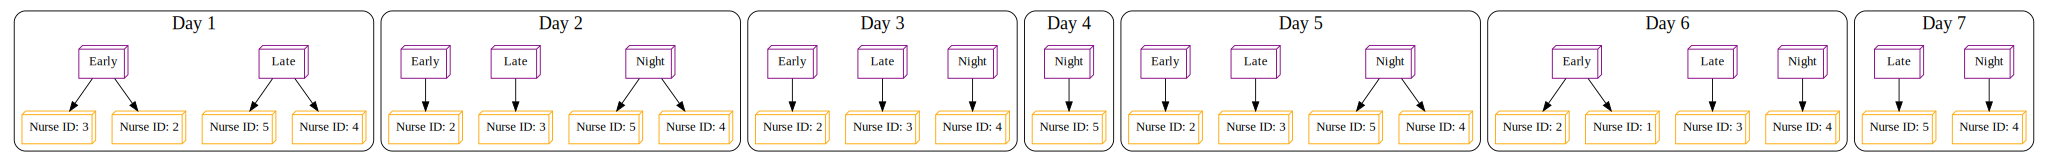

In [ ]:
import graphviz

p = graphviz.Digraph('parent')
p.attr(compound='true')

nDays = 7;
edges = []
id = 0

roster = sorted(roster, key=lambda item: item[1])
roster.reverse()
       
for day in range (1, nDays+1):
    with p.subgraph(name='cluster'+str(day), node_attr={'shape': 'box3d', 'color': 'purple', 'style':'rounded'}) as c:
      for item in roster:
        #if it is the selected day
        if item[0][0] == day:
          #add the time of day if it doesn't exist already
          c.node(str(item[1])+str(day), item[1])
          #add the nurse
          c.node(str(id), "Nurse ID: " + str(item[0][1]), color='orange')
          #add the edge
          edges.append([str(item[1])+str(day), str(id)])
          id=id+1
      c.attr(label="Day "+str(day))
      c.attr(style='rounded')
      c.attr(fontsize='20')
      

p.edges(edges)


p

We can also display the roster as the timetable for each nurse:

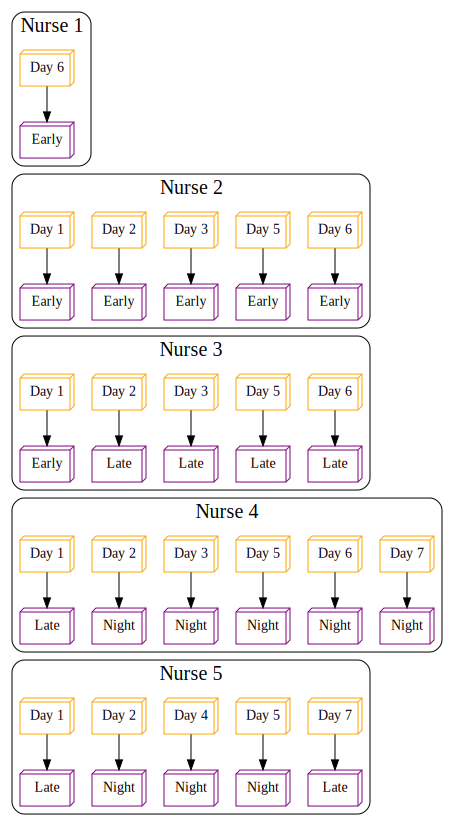

In [ ]:
p = graphviz.Digraph('parent')
p.attr(compound='true')
p.attr(rankdir="TB")

nNurses = 5;
edges = []
id = 0

roster = sorted(roster, key=lambda item: item[0][0])
roster.reverse()
       
for nurse in range (1, nNurses+1):
    with p.subgraph(name='cluster'+str(nurse), node_attr={'shape': 'box3d', 'color': 'purple', 'style':'rounded'}) as c:
      
      for item in roster:
        #if it is the selected nurse
        if item[0][1] == nurse:
          
          #add the day
          c.node(str(id), "Day " + str(item[0][0]), color='orange')

          #add the time of day
          c.node((str(id) + str(item[1]))+str(nurse), item[1])
          
          #add the edge
          edges.append([str(id), (str(id) + str(item[1]))+str(nurse)])
          id=id+1
      c.attr(label="Nurse "+str(nurse))
      c.attr(style='rounded')
      c.attr(fontsize='20')



# force each subgraph to be on new line
p.edge('0Early1', '5', None, {'style':'invis'})
p.edge('5Early2', '10', None, {'style':'invis'})
p.edge('10Early3', '16', None, {'style':'invis'})
p.edge('16Late4', '21', None, {'style':'invis'})

p.edges(edges)

p